In [1]:
from dask.distributed import Client
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import glob
import numpy as np
import rioxarray

import geopandas as gpd 
import fiona 
import pandas as pd 
import datetime as dt
import tqdm

In [2]:
#TODO:
# - Calculate the hourly composites for the entire archive (and merge into yearly files)
# - Do wind speed comparison between GWA and BARRA.
# - Convert time to LST
# - Calculate statistical significance via bootstrapping
# - Upload Class II GWA map
# - Demand data
# - REZ shapefiles
# - Installed wind farm locations?
# - Filter REZs for ones that include wind
# - Look at diurnal variability on NEM-wide wind drought days?

In [3]:
f=gpd.read_file("/g/data/ng72/ab4502/Indicative_REZ_boundaries_2024_GIS_data.kml")
#https://aemo.com.au/-/media/files/major-publications/isp/2024/appendices/a3-renewable-energy-zones.pdf?la=en

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)


In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33871,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:39729,Total threads: 2
Dashboard: /proxy/42267/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:35041,


In [5]:
uname = "ua100m"
vname = "va100m"

files = np.sort(glob.glob("/scratch/ng72/ab4502/hourly_composites/barra_c/barra_c_hourly_"+uname+"_"+vname+"*.nc"))
file_dates = [pd.to_datetime(f.split("/")[-1].split("_")[-2]) for f in files]
file_years = np.array([d.year for d in file_dates])
file_months = np.array([d.month for d in file_dates])

In [6]:
uname = "ua100m"
vname = "va100m"

files_r = np.sort(glob.glob("/scratch/ng72/ab4502/hourly_composites/barra_r/barra_r_hourly_"+uname+"_"+vname+"*.nc"))
file_r_dates = [pd.to_datetime(f.split("/")[-1].split("_")[-2]) for f in files_r]
file_r_years = np.array([d.year for d in file_r_dates])
file_r_months = np.array([d.month for d in file_r_dates])

In [11]:
ds_warm = xr.open_mfdataset(
    files[np.in1d(file_months,[11,12,1,2,3,4])],
    concat_dim=xr.DataArray(np.array(file_dates)[np.in1d(file_months,[11,12,1,2,3,4])],dims="month"),
    combine="nested"
)
ds_cool = xr.open_mfdataset(
    files[np.in1d(file_months,[5,6,7,8,9,10])],
    concat_dim=xr.DataArray(np.array(file_dates)[np.in1d(file_months,[5,6,7,8,9,10])],dims="month"),
    combine="nested"
)



In [8]:
ds_warm_r = xr.open_mfdataset(
    files_r[np.in1d(file_r_months,[11,12,1,2,3,4])],
    concat_dim=xr.DataArray(np.array(file_r_dates)[np.in1d(file_r_months,[11,12,1,2,3,4])],dims="month"),
    combine="nested"
)
ds_cool_r = xr.open_mfdataset(
    files_r[np.in1d(file_r_months,[5,6,7,8,9,10])],
    concat_dim=xr.DataArray(np.array(file_r_dates)[np.in1d(file_r_months,[5,6,7,8,9,10])],dims="month"),
    combine="nested"
)



In [9]:
ds = xr.concat([ds_warm, ds_cool],dim="month")

In [10]:
ds_r = xr.concat([ds_warm_r, ds_cool_r],dim="month")

In [12]:
ds_gwa = ds.sel( month = (ds.month >= pd.to_datetime("2008-01-01")) & (ds.month < pd.to_datetime("2018-01-01")))
cf_gwa_mean = ds_gwa.cf.mean("month").persist()
ws_gwa_mean = ds_gwa.ws.mean("month").persist()

In [17]:
ds_gwa_r = ds_r.sel( month = (ds_r.month >= pd.to_datetime("2008-01-01")) & (ds_r.month < pd.to_datetime("2018-01-01")))
cf_gwa_mean_r = ds_gwa_r.cf.mean("month").persist()
ws_gwa_mean_r = ds_gwa_r.ws.mean("month").persist()

In [13]:
gwa_cf = rioxarray.open_rasterio("/g/data/ng72/ab4502/AUS_capacity-factor_IEC2.tif").squeeze().\
    interp(x=ds.lon.values,y=ds.lat.values).rename({"x":"lon","y":"lat"})
gwa_ws = rioxarray.open_rasterio("/g/data/ng72/ab4502/AUS_wind-speed_100m.tif").squeeze().\
    interp(x=ds.lon.values,y=ds.lat.values).rename({"x":"lon","y":"lat"})

In [19]:
gwa_cf_r = rioxarray.open_rasterio("/g/data/ng72/ab4502/AUS_capacity-factor_IEC2.tif").squeeze().\
    interp(x=ds_r.lon.values,y=ds_r.lat.values).rename({"x":"lon","y":"lat"})
gwa_ws_r = rioxarray.open_rasterio("/g/data/ng72/ab4502/AUS_wind-speed_100m.tif").squeeze().\
    interp(x=ds_r.lon.values,y=ds_r.lat.values).rename({"x":"lon","y":"lat"})

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 10.52 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 10.52 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


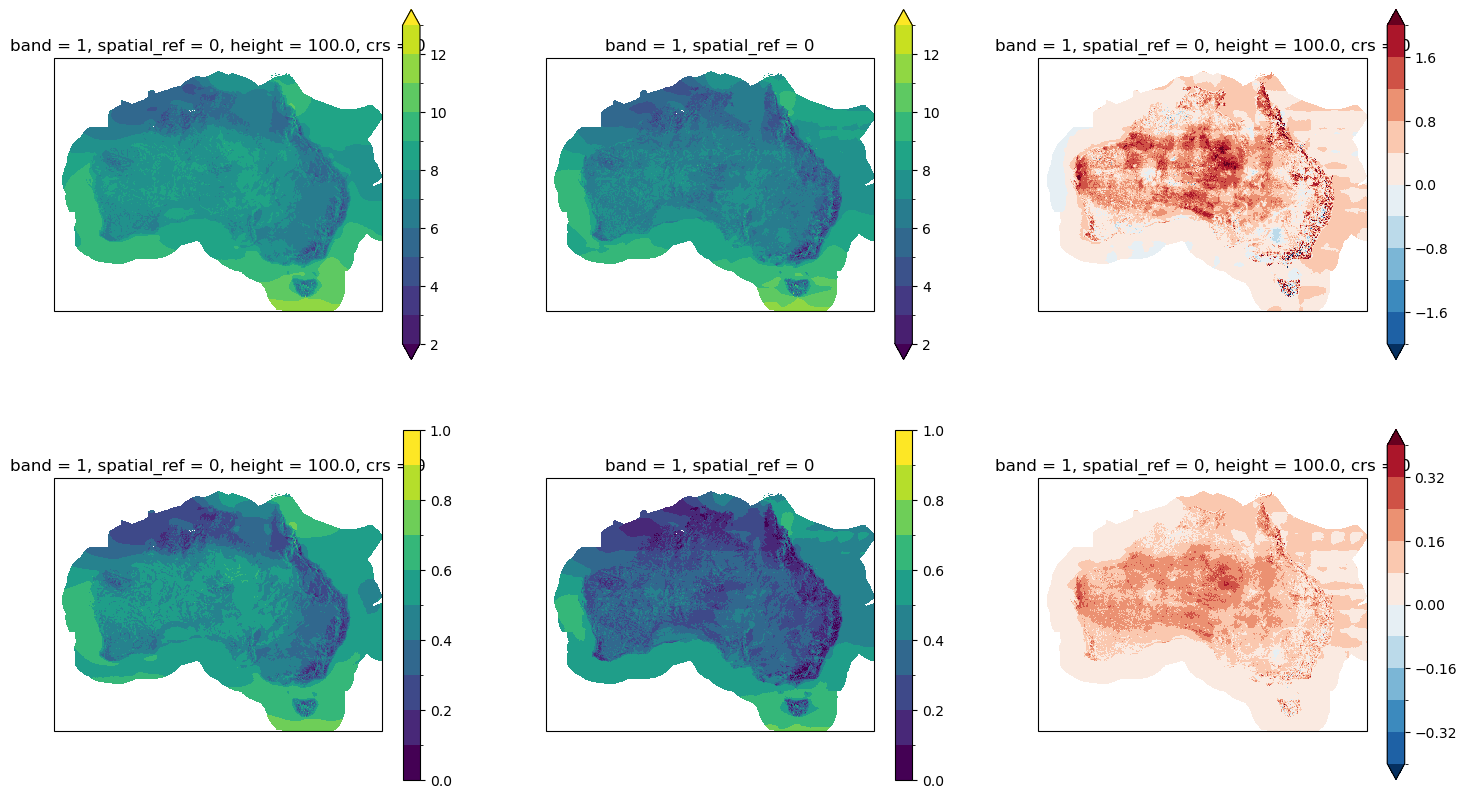

In [16]:
plt.figure(figsize=[18,10])

levels = np.linspace(2,13,12)

ax=plt.subplot(2,3,1,projection=ccrs.PlateCarree())
xr.where(gwa_ws.isnull(),np.nan,ws_gwa_mean.mean("hour")).plot(levels=levels,extend="both")

ax=plt.subplot(2,3,2,projection=ccrs.PlateCarree())
(gwa_ws).plot(levels=levels,extend="both")

ax=plt.subplot(2,3,3,projection=ccrs.PlateCarree())
(xr.where(gwa_ws.isnull(),np.nan,ws_gwa_mean.mean("hour")) - gwa_ws).plot(levels=np.linspace(-2,2,11),extend="both")


levels = np.linspace(0,1,11)

ax=plt.subplot(2,3,4,projection=ccrs.PlateCarree())
xr.where(gwa_cf.isnull(),np.nan,cf_gwa_mean.mean("hour")).plot(levels=levels)

ax=plt.subplot(2,3,5,projection=ccrs.PlateCarree())
(gwa_cf).plot(levels=levels)

ax=plt.subplot(2,3,6,projection=ccrs.PlateCarree())
(xr.where(gwa_cf.isnull(),np.nan,cf_gwa_mean.mean("hour")) - gwa_cf).plot(levels=np.linspace(-0.4,0.4,11),extend="both")

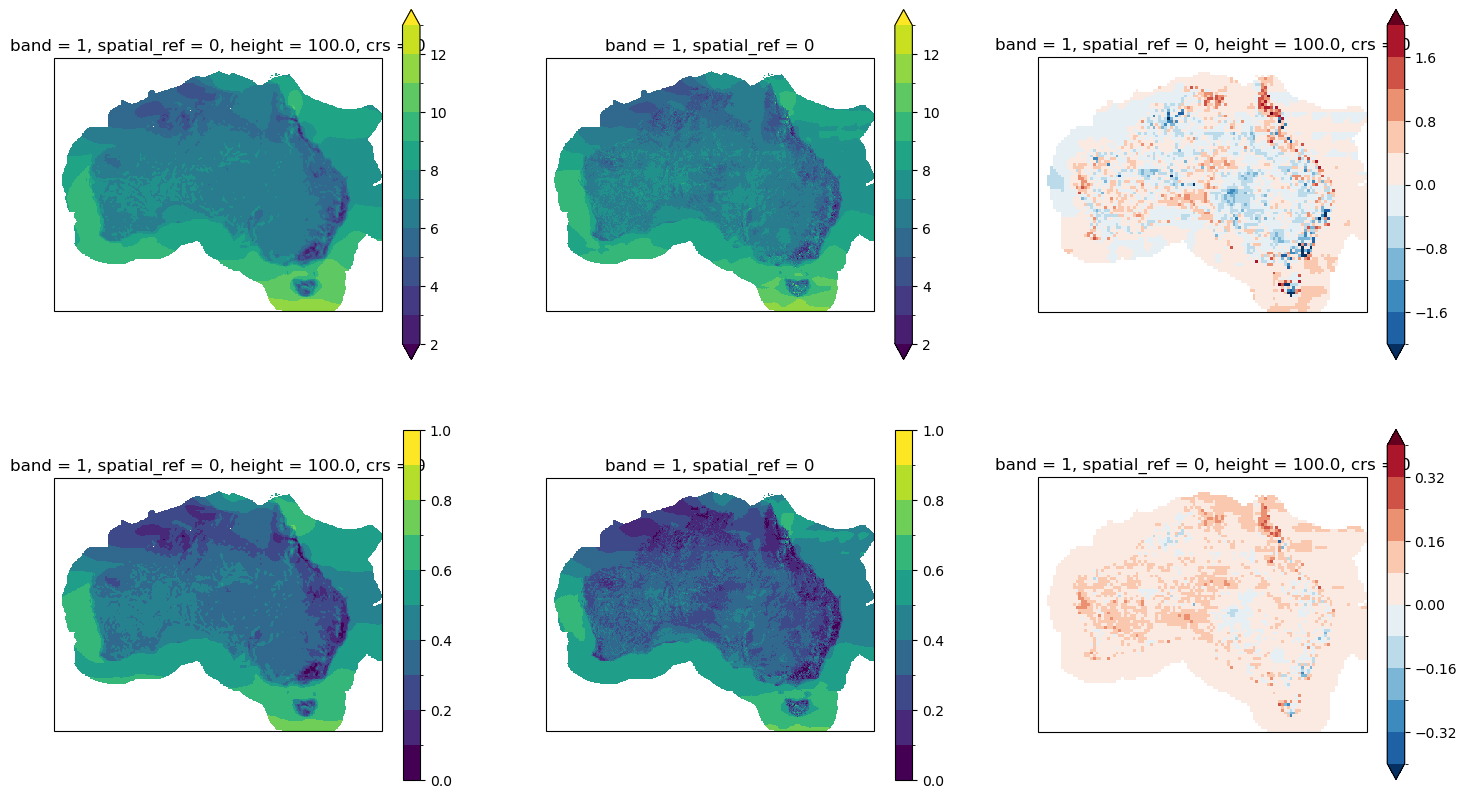

In [20]:
plt.figure(figsize=[18,10])

levels = np.linspace(2,13,12)

ax=plt.subplot(2,3,1,projection=ccrs.PlateCarree())
xr.where(gwa_ws_r.isnull(),np.nan,ws_gwa_mean_r.mean("hour")).plot(levels=levels,extend="both")

ax=plt.subplot(2,3,2,projection=ccrs.PlateCarree())
(gwa_ws_r).plot(levels=levels,extend="both")

ax=plt.subplot(2,3,3,projection=ccrs.PlateCarree())
(xr.where(gwa_ws_r.isnull(),np.nan,ws_gwa_mean_r.mean("hour")) - gwa_ws).plot(levels=np.linspace(-2,2,11),extend="both")


levels = np.linspace(0,1,11)

ax=plt.subplot(2,3,4,projection=ccrs.PlateCarree())
xr.where(gwa_cf_r.isnull(),np.nan,cf_gwa_mean_r.mean("hour")).plot(levels=levels)

ax=plt.subplot(2,3,5,projection=ccrs.PlateCarree())
(gwa_cf_r).plot(levels=levels)

ax=plt.subplot(2,3,6,projection=ccrs.PlateCarree())
(xr.where(gwa_cf_r.isnull(),np.nan,cf_gwa_mean_r.mean("hour")) - gwa_cf).plot(levels=np.linspace(-0.4,0.4,11),extend="both")

In [19]:
cf_mean = ds.cf.mean("month").persist()
ws_mean = ds.ws.mean("month").persist()

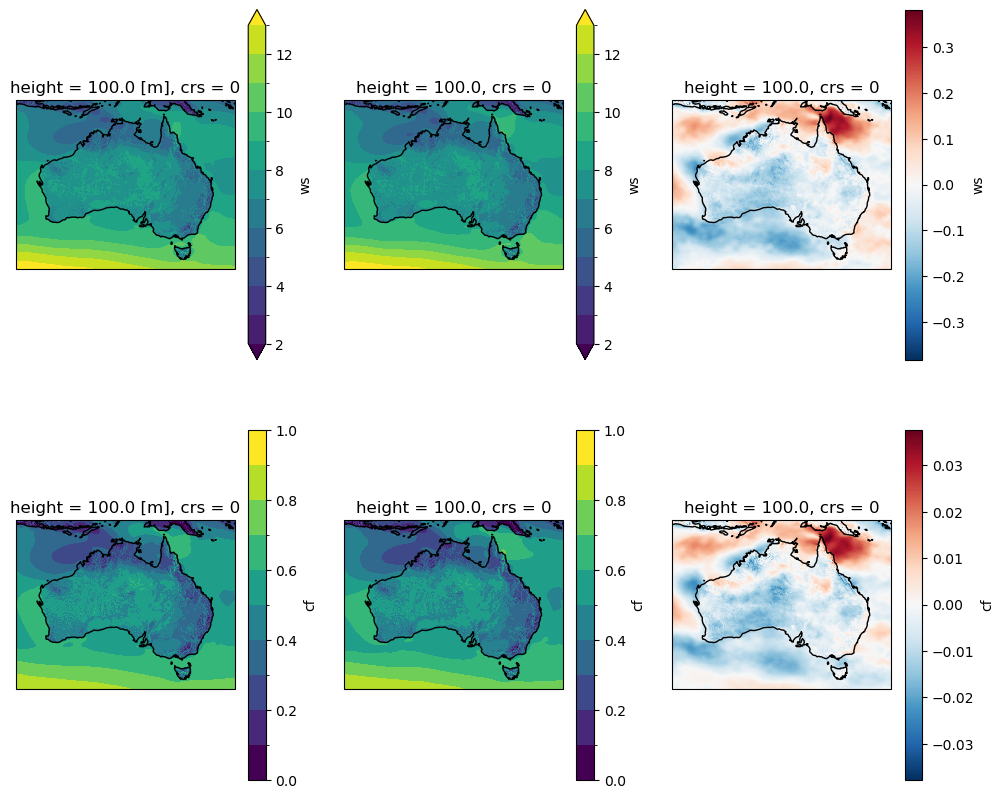

In [32]:
plt.figure(figsize=[12,10])

ax=plt.subplot(2,3,1,projection=ccrs.PlateCarree())
ws_mean.mean("hour").plot(levels = np.linspace(2,13,12))
ax.coastlines()

ax=plt.subplot(2,3,2,projection=ccrs.PlateCarree())
ws_gwa_mean.mean("hour").plot(levels = np.linspace(2,13,12))
ax.coastlines()

ax=plt.subplot(2,3,3,projection=ccrs.PlateCarree())
(ws_gwa_mean - ws_mean).mean("hour").plot()
ax.coastlines()


ax=plt.subplot(2,3,4,projection=ccrs.PlateCarree())
cf_mean.mean("hour").plot(levels = np.linspace(0,1,11))
ax.coastlines()

ax=plt.subplot(2,3,5,projection=ccrs.PlateCarree())
cf_gwa_mean.mean("hour").plot(levels = np.linspace(0,1,11))
ax.coastlines()

ax=plt.subplot(2,3,6,projection=ccrs.PlateCarree())
(cf_gwa_mean - cf_mean).mean("hour").plot()
ax.coastlines()

In [11]:
#Note the GWA is modelled on years 2008-2017

In [10]:
warm_mean = ds_warm.cf.mean("month").persist()

In [11]:
cool_mean = ds_cool.cf.mean("month").persist()

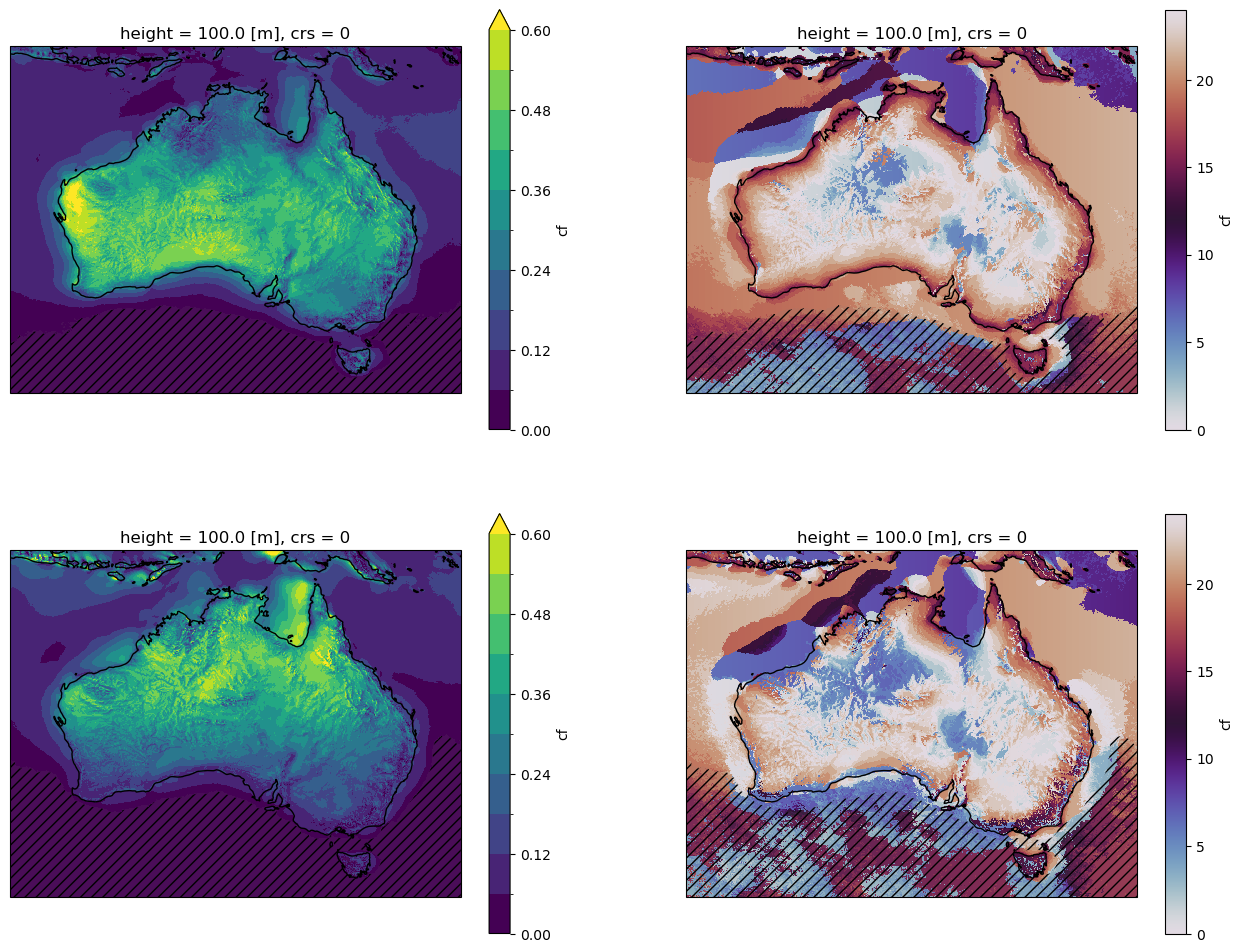

In [42]:
xx,yy = np.meshgrid(ds.lon.values,ds.lat.values)

plt.figure(figsize=[16,12])

ax=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
(warm_mean.max("hour") - warm_mean.min("hour")).plot(levels=np.linspace(0,0.6,11),extend="max")
xr.plot.contourf(((warm_mean.max("hour") - warm_mean.min("hour")) / warm_mean.max("hour")) < 0.05, levels=[0.5,1.5],extend="neither",colors=['grey'],hatches=['///'],alpha=0.1,add_colorbar=False)
ax.coastlines()


ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
#warm_mean_lt.argmax("hour").plot(levels=np.arange(0,25,1),cmap="twilight")
((warm_mean.argmax("hour") + (xx / 180 * 12)) % 24).plot(cmap="twilight",vmin=0,vmax=24)
xr.plot.contourf(((warm_mean.max("hour") - warm_mean.min("hour")) / warm_mean.max("hour")) < 0.05, levels=[0.5,1.5],extend="neither",colors=['grey'],hatches=['///'],alpha=0.1,add_colorbar=False)
ax.coastlines()

#f.plot(ax=ax,alpha=1,edgecolor="k",facecolor="none",ls="-",lw=2)


ax=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
(cool_mean.max("hour") - cool_mean.min("hour")).plot(levels=np.linspace(0,0.6,11),extend="max")
xr.plot.contourf(((cool_mean.max("hour") - cool_mean.min("hour")) / cool_mean.max("hour")) < 0.05, levels=[0.5,1.5],extend="neither",colors=['grey'],hatches=['///'],alpha=0.1,add_colorbar=False)
ax.coastlines()

ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
#cool_mean_lt.argmax("hour").plot(levels=np.arange(0,25,1),cmap="twilight")
((cool_mean.argmax("hour") + (xx / 180 * 12)) % 24).plot(cmap="twilight",vmin=0,vmax=24)
ax.coastlines()
xr.plot.contourf(((cool_mean.max("hour") - cool_mean.min("hour")) / cool_mean.max("hour")) < 0.05, levels=[0.5,1.5],extend="neither",colors=['grey'],hatches=['///'],alpha=0.1,add_colorbar=False)

In [10]:
from rasterio import features
from affine import Affine

def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('lat', 'lon'))

shapes = [(shape, n) for n, shape in enumerate(f.geometry)]
raster = rasterize(shapes,{"lat":ds.lat,"lon":ds.lon},fill=np.nan)

In [11]:
angle_ds = xr.open_dataset("/g/data/ng72/ab4502/coastline_data/barra_c.nc").sel(lon=ds.lon,lat=ds.lat)
f["dist_from_coast"] = angle_ds.min_coast_dist.groupby(raster).mean().values

100%|██████████| 43/43 [00:05<00:00,  8.20it/s]


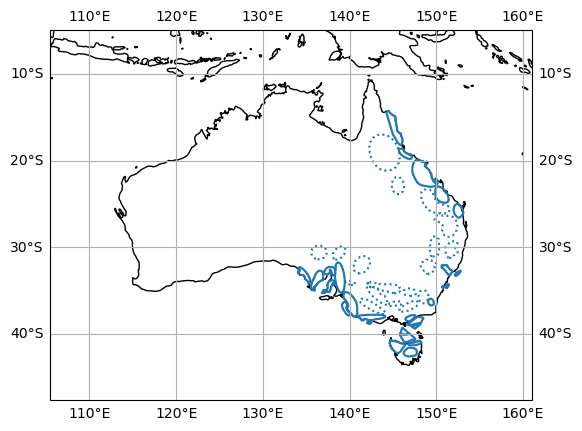

In [15]:
ax=plt.axes(projection=ccrs.PlateCarree())
for i in tqdm.tqdm(range(f.shape[0])):
    if f.iloc[i].dist_from_coast < 100:
        ls = "-"
    else:
        ls = ":"
    xr.plot.contour(raster==i,add_colorbar=False,levels=1,colors="tab:blue",linestyles=ls)
ax.coastlines()
ax.gridlines(draw_labels=True)

In [12]:
warm_mean_demand = ds_warm.cf.sel( month = (ds_warm.month >= pd.to_datetime("2010-01-01")) & (ds.month < pd.to_datetime("2020-01-01"))).mean("month").persist()
cool_mean_demand = ds_cool.cf.sel( month = (ds_cool.month >= pd.to_datetime("2010-01-01")) & (ds.month < pd.to_datetime("2020-01-01"))).mean("month").persist()

2025-07-30 15:43:41,636 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:44131 -> tcp://127.0.0.1:34311
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/worker.py", line 1797, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^

In [22]:
lst_da_ls = []
for h in np.arange(0,24):
    lst = [dt.datetime(2000,1,1,h) + dt.timedelta(hours=l / 180 * 12) for l in ds.lon.values]
    lst = np.array(pd.to_datetime(lst).round("h").hour)
    lst_arr = np.repeat(lst[np.newaxis,:],ds.lat.shape,axis=0)
    lst_da = xr.DataArray(data=lst_arr,dims=["lat","lon"],coords={"lat":ds.lat,"lon":ds.lon})
    lst_da_ls.append(lst_da)

lst_da = xr.concat(lst_da_ls,dim="hour")
lst_da = lst_da.assign_coords({"hour":np.arange(0,24)})

warm_mean_demand_lt = xr.concat([warm_mean_demand.where(lst_da==h,drop=True).mean("hour") for h in np.arange(24)],dim="hour").chunk({"lon":-1}).interpolate_na(dim="lon").persist()
cool_mean_demand_lt = xr.concat([cool_mean_demand.where(lst_da==h,drop=True).mean("hour") for h in np.arange(24)],dim="hour").chunk({"lon":-1}).interpolate_na(dim="lon").persist()

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 35.07 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 35.07 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [23]:
warm_lt_rez_argmax = warm_mean_demand_lt.argmax("hour").groupby(raster).median()
f["warm_argmax_lt"] = warm_lt_rez_argmax.values


cool_lt_rez_argmax = cool_mean_demand_lt.argmax("hour").groupby(raster).median()
f["cool_argmax_lt"] = cool_lt_rez_argmax.values

In [12]:
def load_nemosis(path,region=None):

    df = pd.read_csv(path,skiprows=[0])
    df["SETTLEMENTDATE"] = pd.to_datetime(df["SETTLEMENTDATE"])
    df = df[["SETTLEMENTDATE","REGIONID","TOTALDEMAND"]].dropna()
    df = df.drop_duplicates(["SETTLEMENTDATE","REGIONID"])
    
    if region is None:
        df = df.groupby("SETTLEMENTDATE").sum()
        df = df.loc[df.index.minute == 0]
        return df[["TOTALDEMAND"]]
    else:
        df = df[df["REGIONID"]==region]
        df = df.set_index("SETTLEMENTDATE").sort_index()
        df = df.loc[df.index.minute == 0]
        return df

In [ ]:
nemosis_files = np.sort(glob.glob("/g/data/ng72/ab4502/nemosis/*.CSV"))
demand = pd.concat([load_nemosis(f) for f in tqdm.tqdm(nemosis_files)],axis=0)

100%|██████████| 122/122 [01:10<00:00,  1.73it/s]


<Axes: xlabel='SETTLEMENTDATE'>

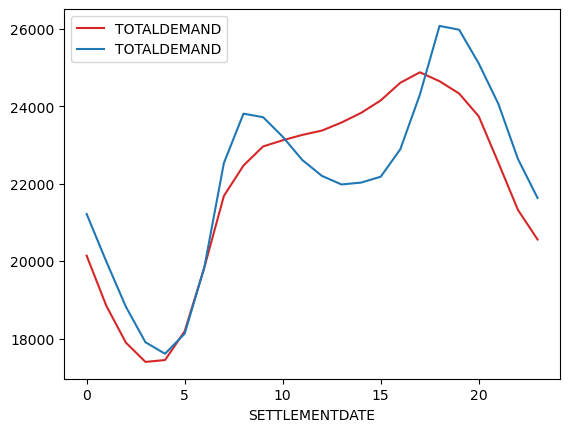

In [25]:
demand_warm = demand.iloc[(np.in1d(demand.index.month,[11,12,1,2,3,4])) & (demand.index.year >= 2010) & (demand.index.year <= 2019)]
demand_cool = demand.iloc[(np.in1d(demand.index.month,[5,6,7,8,9,10])) & (demand.index.year >= 2010) & (demand.index.year <= 2019)]

ax=plt.axes()
demand_warm.groupby(demand_warm.index.hour).mean().plot(color="tab:red",ax=ax)
demand_cool.groupby(demand_cool.index.hour).mean().plot(color="tab:blue",ax=ax)

Text(0.5, 1.0, 'Cool season (May-October)')

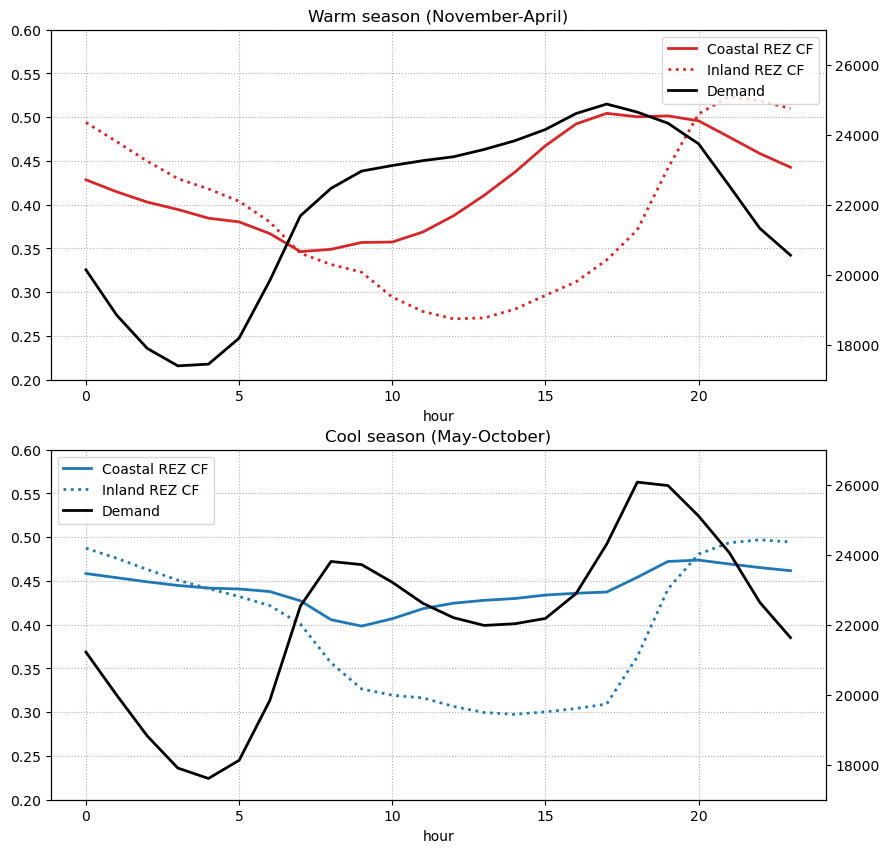

In [26]:
plt.figure(figsize=[10,10])
ax=plt.subplot(2,1,1)
l1=xr.where(raster.isin(f.query("dist_from_coast<100").index),warm_mean_demand_lt,np.nan).mean(("lat","lon")).plot(ax=ax,color="tab:red",lw=2)
l2=xr.where(raster.isin(f.query("dist_from_coast>=100").index),warm_mean_demand_lt,np.nan).mean(("lat","lon")).plot(ax=ax,color="tab:red",ls=":",lw=2)
ax2=ax.twinx()
l3=demand_warm.groupby(demand_warm.index.hour).mean().plot(color="k",ax=ax2,legend=False,lw=2)
ax.set_ylim([0.2,0.6])
ax2.set_ylim([17000,27000])
ax.grid(ls=":")
ax.set_title("Warm season (November-April)")
plt.legend([l1[0],l2[0],l3.lines[0]],["Coastal REZ CF","Inland REZ CF","Demand"])

ax=plt.subplot(2,1,2)
l1=xr.where(raster.isin(f.query("dist_from_coast<100").index),cool_mean_demand_lt,np.nan).mean(("lat","lon")).plot(color="tab:blue",lw=2)
l2=xr.where(raster.isin(f.query("dist_from_coast>=100").index),cool_mean_demand_lt,np.nan).mean(("lat","lon")).plot(color="tab:blue",ls=":",lw=2)
ax2=ax.twinx()
l3=demand_cool.groupby(demand_cool.index.hour).mean().plot(color="k",ax=ax2,legend=False,lw=2)
ax.set_ylim([0.2,0.6])
plt.legend([l1[0],l2[0],l3.lines[0]],["Coastal REZ CF","Inland REZ CF","Demand"])
ax2.set_ylim([17000,27000])
ax.grid(ls=":")
ax.set_title("Cool season (May-October)")

Text(0.5, 1.0, 'Cool season (May-October)')

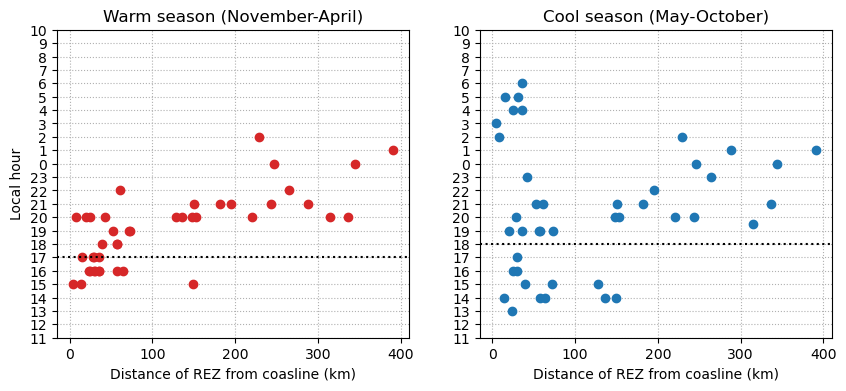

In [27]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)

x = f.dist_from_coast.values
y = f.warm_argmax_lt.values
y[y<10] = y[y<10]+24

plt.plot(x,y,marker="o",ls="none",color="tab:red")

ticks = np.arange(11,35)
tick_labels = np.copy(ticks)
tick_labels[ticks>=24] = tick_labels[tick_labels>=24] - 24
plt.yticks(ticks,tick_labels.astype(str));
#plt.ylim([14,28])
plt.gca().grid(ls=":")
plt.gca().axhline(demand_warm.groupby(demand_warm.index.hour).mean().idxmax().values[0],color="k",ls=":")

plt.xlabel("Distance of REZ from coasline (km)")
plt.ylabel("Local hour")
plt.title("Warm season (November-April)")


plt.subplot(1,2,2)

x = f.dist_from_coast.values
y = f.cool_argmax_lt.values
y[y<10] = y[y<10]+24

plt.plot(x,y,marker="o",ls="none",color="tab:blue")

ticks = np.arange(11,35)
tick_labels = np.copy(ticks)
tick_labels[ticks>=24] = tick_labels[tick_labels>=24] - 24
plt.yticks(ticks,tick_labels.astype(str));
#plt.ylim([14,28])
plt.gca().grid(ls=":")


plt.gca().axhline(demand_cool.groupby(demand_cool.index.hour).mean().idxmax().values[0],color="k",ls=":")

plt.xlabel("Distance of REZ from coasline (km)")
plt.ylabel("")
plt.title("Cool season (May-October)")

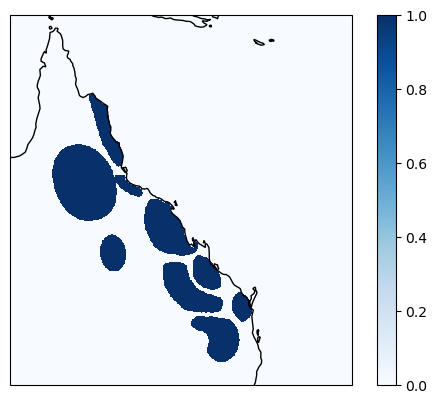

In [13]:
qld_lat_slice = slice(-30,-10)
qld_lon_slice = slice(140,158.5)


rez_states = np.array([n[0] for n in f["Name"]])

s="Q"
ax=plt.axes(projection=ccrs.PlateCarree())
raster.isin(np.where(rez_states==s)).sel(lat=qld_lat_slice,lon=qld_lon_slice).plot(cmap="Blues")
ax.coastlines()

In [14]:
orog = xr.open_dataset("/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/fx/orog/latest/orog_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1.nc")

In [15]:
qld_mean = ds.sel(lat=qld_lat_slice,lon=qld_lon_slice).cf.mean("month").persist()

In [16]:
lst_da_ls = []
for h in np.arange(0,24):
    lst = [dt.datetime(2000,1,1,h) + dt.timedelta(hours=l / 180 * 12) for l in qld_mean.lon.values]
    lst = np.array(pd.to_datetime(lst).round("h").hour)
    lst_arr = np.repeat(lst[np.newaxis,:],qld_mean.lat.shape,axis=0)
    lst_da = xr.DataArray(data=lst_arr,dims=["lat","lon"],coords={"lat":qld_mean.lat,"lon":qld_mean.lon})
    lst_da_ls.append(lst_da)

lst_da = xr.concat(lst_da_ls,dim="hour")
lst_da = lst_da.assign_coords({"hour":np.arange(0,24)})

qld_mean_lt = xr.concat([qld_mean.where(lst_da==h,drop=True).mean("hour") for h in np.arange(24)],dim="hour").chunk({"lon":-1}).interpolate_na(dim="lon").persist()


In [ ]:
nemosis_files = np.sort(glob.glob("/g/data/ng72/ab4502/nemosis/*.CSV"))
qld_demand = pd.concat([load_nemosis(f,region="QLD1") for f in tqdm.tqdm(nemosis_files)],axis=0)
qld_demand = qld_demand.iloc[(qld_demand.index.year >= 2010) & (qld_demand.index.year <= 2019)]

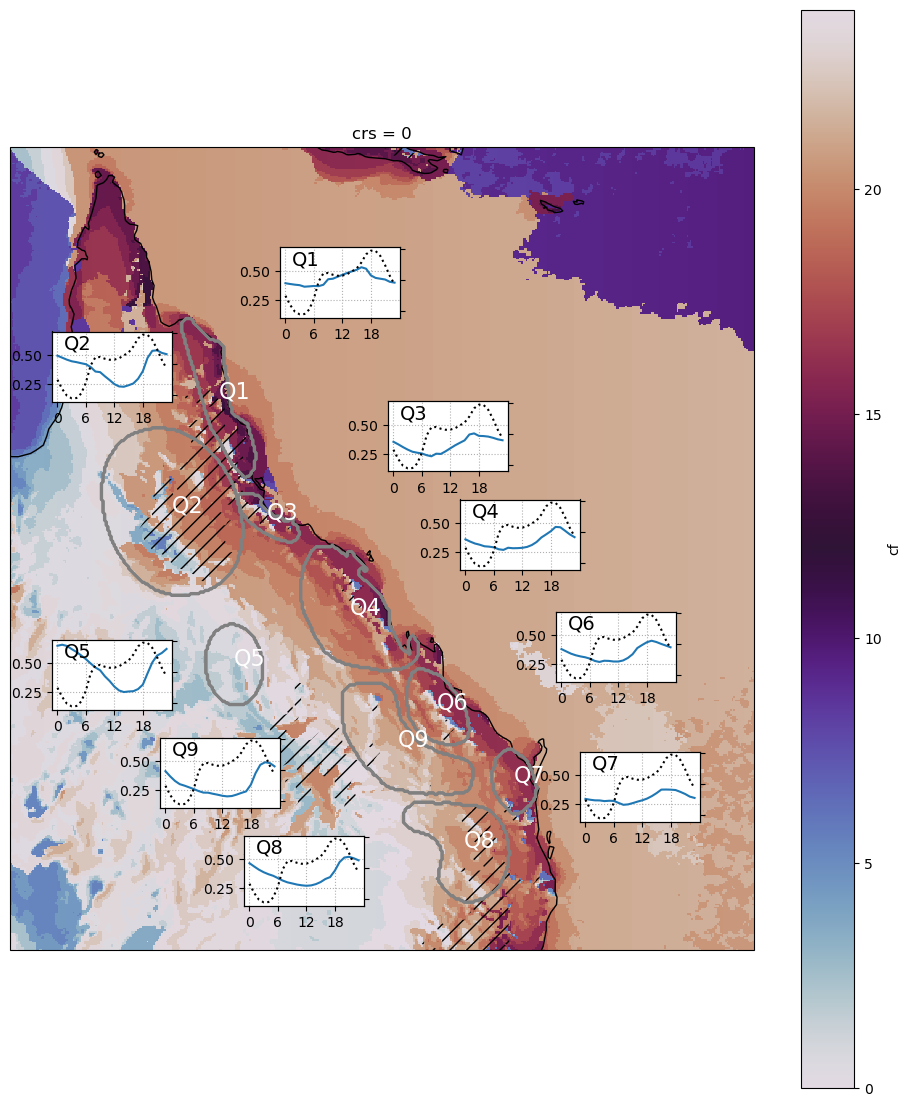

In [100]:
plt.figure(figsize=[12,14])

xx,yy=np.meshgrid(qld_mean.lon.values,qld_mean.lat.values)

ax=plt.axes(projection=ccrs.PlateCarree())
((qld_mean.argmax("hour") + (xx / 180 * 12)) % 24).plot(cmap="twilight",vmin=0,vmax=24)
xr.plot.contourf(((qld_mean.max("hour") - qld_mean.min("hour")) / qld_mean.max("hour")) < 0.05, levels=[0.5,1.5],extend="neither",colors=['grey'],hatches=['///'],alpha=0.1,add_colorbar=False)
ax.coastlines()

[xr.plot.contour(raster.sel(lat=qld_lat_slice,lon=qld_lon_slice) == i,add_colorbar=False,colors="grey") for i in np.where(rez_states == "Q")[0]];
#xr.plot.contour(orog.sel(lat=qld_lat_slice,lon=qld_lon_slice).orog,levels=[500],colors="k",linewidths=0.5)
xr.plot.contourf(orog.sel(lat=qld_lat_slice,lon=qld_lon_slice).orog,levels=[0,500],colors=["none"],hatches=["","//"],extend="max",add_colorbar=False)


xlocs = [0.35,0.16,0.44,0.5,0.16,.58,0.60,0.32,0.25]
ylocs = [0.66,0.60,0.55,0.48,0.38,.4,0.30,0.24,0.31]

qld_demand_hour = qld_demand.TOTALDEMAND.groupby(qld_demand.index.hour).mean()

for i in [0,1,2,3,4,5,6,7,8]:

    ax.text(
        xr.where(raster.sel(lat=qld_lat_slice,lon=qld_lon_slice) == i,xx,np.nan).mean(),
        xr.where(raster.sel(lat=qld_lat_slice,lon=qld_lon_slice) == i,yy,np.nan).mean(),
        "Q"+str(i+1),size=16,color="white")
    
    sub_ax=plt.axes([xlocs[i],ylocs[i],0.1,0.05])
    xr.where(raster.sel(lat=qld_lat_slice,lon=qld_lon_slice) == i,qld_mean_lt,np.nan).mean(("lat","lon")).plot()
    sub_ax.set_title("")

    sub_ax.text(0.1,0.75,"Q"+str(i+1),transform=sub_ax.transAxes,size=14)
    sub_ax.set_xlabel("")
    sub_ax.set_ylim([0.1,0.7])
    sub_ax.grid(ls=":")

    sub_ax.set_xticks([0,6,12,18])

    ax2 = sub_ax.twinx()
    ax2.plot(qld_demand_hour,ls=":",color="k")
    ax2.set_yticklabels("")
    